In [1]:
import torch
# GPU 사용 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

# CUDA 사용 가능 여부 확인
print(f"CUDA available: {torch.cuda.is_available()}")  # True여야 함

# PyTorch에서 사용하는 CUDA 버전 확인
print(f"CUDA version in PyTorch: {torch.version.cuda}")

cuda
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA available: True
CUDA version in PyTorch: 11.8


In [2]:
# 라이브러리 임포트
import os
import shutil
import random
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
import matplotlib.pyplot as plt

In [3]:
# 하이퍼파라미터 설정
IMAGE_SIZE = 64
BATCH_SIZE = 64
N_EPOCHS = 20

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

In [4]:
import os
print(os.getcwd())

d:\sy\code


In [5]:
# 데이터세트 디렉토리 설정
original_dir = '../PCB_imgs/all'
original_dataset = ImageFolder(root=original_dir, transform=transform)

# 데이터세트 DataLoader로 변환
original_loader = DataLoader(original_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 데이터 분할
file_paths = [img[0] for img in original_dataset.imgs]
targets = original_dataset.targets

train_images, test_images, train_targets, test_targets = train_test_split(
    file_paths, targets, stratify=targets, test_size=0.2, random_state=124
)

train_images, validation_images, train_targets, validation_targets = train_test_split(
    train_images, train_targets, stratify=train_targets, test_size=0.2, random_state=124
)

# DataFrame 생성
train_df = pd.DataFrame({'file_paths': train_images, 'targets': train_targets})
validation_df = pd.DataFrame({'file_paths': validation_images, 'targets': validation_targets})
test_df = pd.DataFrame({'file_paths': test_images, 'targets': test_targets})

In [6]:
# 각 클래스의 이미지 수 확인
print(f'train_ng: {sum(train_df['targets'] == 0)}개')  # 0이 ng 클래스인 경우
print(f'train_ok: {sum(train_df['targets'] == 1)}개')  # 1이 ok 클래스인 경우
print(f'test_ng: {sum(test_df['targets'] == 0)}개') 
print(f'test_ok: {sum(test_df['targets'] == 1)}개') 
print(f'val_ng: {sum(validation_df['targets'] == 0)}개') 
print(f'val_ok: {sum(validation_df['targets'] == 1)}개')  

train_ng: 1178개
train_ok: 830개
test_ng: 368개
test_ok: 260개
val_ng: 294개
val_ok: 208개


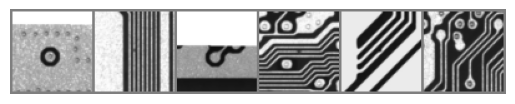

OK    NG    OK    NG    NG    OK   


In [33]:
classes = ('NG', 'OK')

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 축 숨기기
    plt.show()

# 이미지를 무작위로 가져오기
dataiter = iter(original_loader)
images, labels = next(dataiter)

# 6개의 이미지와 레이블만 가져오기
images = images[:6]  # 첫 6개 이미지
labels = labels[:6]  # 첫 6개 레이블

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))  # labels의 길이에 따라 반복

In [44]:
# 커스텀 데이터세트 정의
class CustomDataset(Dataset):
    def __init__(self, file_paths, targets, aug=None, preprocess=None):
        self.file_paths = file_paths
        self.targets = targets
        self.aug = aug
        self.preprocess = preprocess

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        file_path = self.file_paths[index]
        target = self.targets[index]
        
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        if self.aug is not None:
            image = self.aug(image=image)['image']

        if self.preprocess is not None:
            image = self.preprocess(image)

        image = np.transpose(image, (2, 0, 1))  # (H, W, C) -> (C, H, W)
        image = torch.tensor(image, dtype=torch.float32)
        
        return image, target

In [8]:
# # 데이터 증강 정의
# aug = A.Compose([
#     A.ShiftScaleRotate(p=0.5),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
# ])

In [9]:
# 데이터세트 인스턴스 생성
# train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

In [45]:
# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [46]:
# 모델 정의
class CustomModel(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(CustomModel, self).__init__()
        if model_name == 'vgg16':
            self.base_model = torchvision.models.vgg16(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'resnet50':
            self.base_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
            self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # 마지막 레이어 제거
        elif model_name == 'inception':
            self.base_model = torchvision.models.inception_v3(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거
        elif model_name == 'mobilenet':
            self.base_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
            self.base_model.classifier = nn.Identity()  # 마지막 분류기 제거

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._get_features_dim(model_name), 50)
        self.fc2 = nn.Linear(50, 1)  # Sigmoid 출력

    def _get_features_dim(self, model_name):
        if model_name in ['vgg16', 'inception']:
            return 25088  # VGG16의 출력 차원
        elif model_name == 'resnet50':
            return 2048  # ResNet50의 출력 차원
        elif model_name == 'mobilenet':
            return 1280  # MobileNetV2의 출력 차원

    def forward(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Sigmoid 제거
        # x = torch.sigmoid(self.fc2(x))
        return x

In [47]:
# 모델 초기화
model = CustomModel(model_name='resnet50').to(device)

In [48]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [49]:
# 평가 함수 정의
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device).float()
            outputs = model(images)
            loss = criterion(outputs.view(-1), targets)
            total_loss += loss.item()
            
            predicted = (outputs.view(-1) > 0.5).float()
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [50]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.5310, Train Accuracy: 0.7385, Val Loss: 0.3989, Val Accuracy: 0.7749
Epoch [2/20], Train Loss: 0.3600, Train Accuracy: 0.8162, Val Loss: 0.3059, Val Accuracy: 0.8625
Epoch [3/20], Train Loss: 0.3046, Train Accuracy: 0.8710, Val Loss: 0.2564, Val Accuracy: 0.8884
Epoch [4/20], Train Loss: 0.2469, Train Accuracy: 0.8964, Val Loss: 0.2735, Val Accuracy: 0.8984
Epoch [5/20], Train Loss: 0.2064, Train Accuracy: 0.9203, Val Loss: 0.2016, Val Accuracy: 0.9323
Epoch [6/20], Train Loss: 0.1663, Train Accuracy: 0.9373, Val Loss: 0.2459, Val Accuracy: 0.9163
Epoch [7/20], Train Loss: 0.1446, Train Accuracy: 0.9492, Val Loss: 0.2505, Val Accuracy: 0.9104
Epoch [8/20], Train Loss: 0.1738, Train Accuracy: 0.9363, Val Loss: 0.2346, Val Accuracy: 0.9124
Epoch [9/20], Train Loss: 0.1311, Train Accuracy: 0.9482, Val Loss: 0.2559, Val Accuracy: 0.9124
Epoch [10/20], Train Loss: 0.1296, Train Accuracy: 0.9542, Val Loss: 0.2686, Val Accuracy: 0.9064
Epoch [11/20], Train Loss: 0.

In [52]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2449, Test Accuracy: 0.9283


mobilenet 모델

In [23]:
# 모델 초기화
model = CustomModel(model_name='mobilenet').to(device)

In [24]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [34]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.0093, Train Accuracy: 0.9965, Val Loss: 0.4605, Val Accuracy: 0.9064
Epoch [2/20], Train Loss: 0.0150, Train Accuracy: 0.9955, Val Loss: 0.4782, Val Accuracy: 0.8964
Epoch [3/20], Train Loss: 0.0181, Train Accuracy: 0.9935, Val Loss: 0.4725, Val Accuracy: 0.9084
Epoch [4/20], Train Loss: 0.0104, Train Accuracy: 0.9965, Val Loss: 0.4673, Val Accuracy: 0.9104
Epoch [5/20], Train Loss: 0.0141, Train Accuracy: 0.9960, Val Loss: 0.4270, Val Accuracy: 0.9263
Epoch [6/20], Train Loss: 0.0141, Train Accuracy: 0.9950, Val Loss: 0.4540, Val Accuracy: 0.9163
Epoch [7/20], Train Loss: 0.0264, Train Accuracy: 0.9945, Val Loss: 0.4063, Val Accuracy: 0.9183
Epoch [8/20], Train Loss: 0.0156, Train Accuracy: 0.9955, Val Loss: 0.3588, Val Accuracy: 0.9283
Epoch [9/20], Train Loss: 0.0069, Train Accuracy: 0.9980, Val Loss: 0.3427, Val Accuracy: 0.9363
Epoch [10/20], Train Loss: 0.0041, Train Accuracy: 0.9990, Val Loss: 0.3589, Val Accuracy: 0.9263
Epoch [11/20], Train Loss: 0.

In [35]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.3467, Test Accuracy: 0.9379


데이터 증강을 해보자..  
일단 훈련 손실값은 계속 낮아지지만 검증 손실값이 오르락 내리락하는군..

In [36]:
# # 데이터 증강 정의
aug = A.Compose([
    A.ShiftScaleRotate(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0, p=0.5)
])

# 데이터세트 인스턴스 생성
train_dataset = CustomDataset(train_df['file_paths'].values, train_df['targets'].values, aug=aug)
validation_dataset = CustomDataset(validation_df['file_paths'].values, validation_df['targets'].values)
test_dataset = CustomDataset(test_df['file_paths'].values, test_df['targets'].values)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
# 모델 초기화
model = CustomModel(model_name='mobilenet').to(device)

In [38]:
# 손실 함수 및 최적화함수 정의
criterion = nn.BCEWithLogitsLoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam 옵티마이저

In [39]:
# 모델 훈련
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0  # 정확도 계산을 위한 변수
    total_predictions = 0    # 전체 샘플 수

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(images)

        # 손실 계산
        loss = criterion(outputs.view(-1), targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # 정확도 계산
        predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # 확률을 0.5 기준으로 이진 분류
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    # 훈련 데이터 정확도
    train_accuracy = correct_predictions / total_predictions

    # 검증
    val_loss, val_accuracy = evaluate_model(model, validation_loader, criterion)

    print(f'Epoch [{epoch+1}/{N_EPOCHS}], Train Loss: {running_loss / len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch [1/20], Train Loss: 0.5816, Train Accuracy: 0.6927, Val Loss: 0.4305, Val Accuracy: 0.7789
Epoch [2/20], Train Loss: 0.4323, Train Accuracy: 0.7953, Val Loss: 0.3627, Val Accuracy: 0.8008
Epoch [3/20], Train Loss: 0.3643, Train Accuracy: 0.8362, Val Loss: 0.3355, Val Accuracy: 0.8466
Epoch [4/20], Train Loss: 0.3286, Train Accuracy: 0.8421, Val Loss: 0.2983, Val Accuracy: 0.8865
Epoch [5/20], Train Loss: 0.2895, Train Accuracy: 0.8685, Val Loss: 0.2763, Val Accuracy: 0.8805
Epoch [6/20], Train Loss: 0.2811, Train Accuracy: 0.8835, Val Loss: 0.2569, Val Accuracy: 0.9024
Epoch [7/20], Train Loss: 0.2413, Train Accuracy: 0.8994, Val Loss: 0.2505, Val Accuracy: 0.9143
Epoch [8/20], Train Loss: 0.2324, Train Accuracy: 0.9034, Val Loss: 0.2712, Val Accuracy: 0.8904
Epoch [9/20], Train Loss: 0.2013, Train Accuracy: 0.9213, Val Loss: 0.2594, Val Accuracy: 0.9044
Epoch [10/20], Train Loss: 0.1833, Train Accuracy: 0.9258, Val Loss: 0.2639, Val Accuracy: 0.9044
Epoch [11/20], Train Loss: 0.

In [40]:
# 테스트 데이터세트로 평가
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.2799, Test Accuracy: 0.9092


resnet50  
Epoch [20/20], Train Loss: 0.0688, Train Accuracy: 0.9746, Val Loss: 0.2381, Val Accuracy: 0.9303    

mobilenet   
Epoch [20/20], Train Loss: 0.0012, Train Accuracy: 0.9995, Val Loss: 0.4009, Val Accuracy: 0.9243    

mobilenet 데이터 증강 후  
Epoch [20/20], Train Loss: 0.1009, Train Accuracy: 0.9622, Val Loss: 0.3000, Val Accuracy: 0.9124

#### resnet 사전훈련 모델 이용하여 fine tuning 진행